In [5]:
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report
import xgboost as xgb
from hyperopt import hp, fmin, tpe, Trials
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# 데이터 로드 (학습 데이터와 테스트 데이터 파일 경로)
train_file_path = "data/merged_data_2378.csv"
test_file_path = "data/merged_data_520_test.csv"

# 학습 데이터 로드
train_data = pd.read_csv(train_file_path)
X_train = train_data.drop(columns=["within_120hr_death"])  # 'within_120hr_death' 열을 제외한 특성
y_train = train_data["within_120hr_death"]  # 타겟 변수

# 테스트 데이터 로드
test_data = pd.read_csv(test_file_path)
X_test = test_data.drop(columns=["within_120hr_death"])  # 'within_120hr_death' 열을 제외한 특성
y_test = test_data["within_120hr_death"]  # 타겟 변수

# 공통된 열 선택
common_columns = X_train.columns.intersection(X_test.columns)
X_train = X_train[common_columns]
X_test = X_test[common_columns]
print(f"Number of features: {len(common_columns)}")

Number of features: 1015


In [6]:
# 클래스 불균형에 따른 가중치 조정
scale_pos_weight = len(y_train) / (2 * sum(y_train))

# 학습 데이터와 검증 데이터 나누기
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# SMOTE 적용: 훈련 데이터에만
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_split, y_train_split)

# 하이퍼파라미터 검색 공간 정의
xgb_search_space = {
    'max_depth': hp.quniform('max_depth', 5, 20, 1),
    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.2),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
    'subsample': hp.uniform('subsample', 0.5, 1),
    'gamma': hp.uniform('gamma', 0, 1),
    'reg_lambda': hp.uniform('reg_lambda', 0, 2),
    'reg_alpha': hp.uniform('reg_alpha', 0, 2),
}

# 하이퍼파라미터 튜닝을 위한 목적 함수 정의
def objective_func(search_space):
    # XGBClassifier 모델 설정
    model = xgb.XGBClassifier(
        n_estimators=350,
        learning_rate=search_space['learning_rate'],
        max_depth=int(search_space['max_depth']),
        min_child_weight=int(search_space['min_child_weight']),
        colsample_bytree=search_space['colsample_bytree'],
        subsample=search_space['subsample'],
        gamma=search_space['gamma'],
        reg_lambda=search_space['reg_lambda'],
        reg_alpha=search_space['reg_alpha'],
        scale_pos_weight=scale_pos_weight,
        eval_metric="logloss",
        early_stopping_rounds=10
    )

    # 모델 학습 (early_stopping_rounds를 사용하기 위해 검증 데이터 제공)
    model.fit(
        X_train_resampled, y_train_resampled,
        eval_set=[(X_val_split, y_val_split)],
        verbose=False
    )

    # 검증 데이터에 대한 정확도 계산
    val_accuracy = accuracy_score(y_val_split, model.predict(X_val_split))
    return -val_accuracy  # 최적화는 loss를 최소화해야 하므로 부호 반전

# 하이퍼파라미터 튜닝을 위한 `Trials` 객체 생성
trial_val = Trials()

# fmin을 사용하여 하이퍼파라미터 최적화 수행
best = fmin(
    fn=objective_func,           # 목적 함수
    space=xgb_search_space,      # 하이퍼파라미터 검색 공간
    algo=tpe.suggest,            # 최적화 알고리즘
    max_evals=100,               # 최대 반복 횟수
    trials=trial_val             # 하이퍼파라미터 튜닝의 트레이스 기록
)

# 최적의 하이퍼파라미터 출력
print("Best hyperparameters:", best)

100%|██████████| 100/100 [04:53<00:00,  2.94s/trial, best loss: -0.9663865546218487]
Best hyperparameters: {'colsample_bytree': np.float64(0.8162513583700682), 'gamma': np.float64(0.2879313517776968), 'learning_rate': np.float64(0.18495429520648238), 'max_depth': np.float64(15.0), 'min_child_weight': np.float64(5.0), 'reg_alpha': np.float64(0.8973476213897356), 'reg_lambda': np.float64(1.843172387522842), 'subsample': np.float64(0.6088351472923701)}


In [7]:
# 최적화된 하이퍼파라미터로 XGBoost 모델 학습
best_model = xgb.XGBClassifier(
    n_estimators=350,
    learning_rate=best['learning_rate'],
    max_depth=int(best['max_depth']),
    min_child_weight=int(best['min_child_weight']),
    colsample_bytree=best['colsample_bytree'],
    subsample=best['subsample'],
    gamma=best['gamma'],
    reg_lambda=best['reg_lambda'],
    reg_alpha=best['reg_alpha'],
    scale_pos_weight=scale_pos_weight,
    eval_metric="logloss",
    early_stopping_rounds=10
)

# 모델 학습
best_model.fit(X_train_resampled, y_train_resampled, eval_set=[(X_val_split, y_val_split)], verbose=True)

# Train 데이터 평가
y_train_pred = best_model.predict(X_train_resampled)
train_accuracy = accuracy_score(y_train_resampled, y_train_pred)
print(f"Train Accuracy: {train_accuracy:.4f}")

# Test 데이터 평가
y_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Test Accuracy: {test_accuracy:.4f}")
print("Classification Report:")
print(report)


[0]	validation_0-logloss:0.83296
[1]	validation_0-logloss:0.68252
[2]	validation_0-logloss:0.58395
[3]	validation_0-logloss:0.51162
[4]	validation_0-logloss:0.44401
[5]	validation_0-logloss:0.39700
[6]	validation_0-logloss:0.35939
[7]	validation_0-logloss:0.32832
[8]	validation_0-logloss:0.30204
[9]	validation_0-logloss:0.28168
[10]	validation_0-logloss:0.25967
[11]	validation_0-logloss:0.24247
[12]	validation_0-logloss:0.23051
[13]	validation_0-logloss:0.21793
[14]	validation_0-logloss:0.20592
[15]	validation_0-logloss:0.19737
[16]	validation_0-logloss:0.19068
[17]	validation_0-logloss:0.18494
[18]	validation_0-logloss:0.18259
[19]	validation_0-logloss:0.17575
[20]	validation_0-logloss:0.17279
[21]	validation_0-logloss:0.17105
[22]	validation_0-logloss:0.16615
[23]	validation_0-logloss:0.16247
[24]	validation_0-logloss:0.16073
[25]	validation_0-logloss:0.15822
[26]	validation_0-logloss:0.15718
[27]	validation_0-logloss:0.15571
[28]	validation_0-logloss:0.15407
[29]	validation_0-loglos

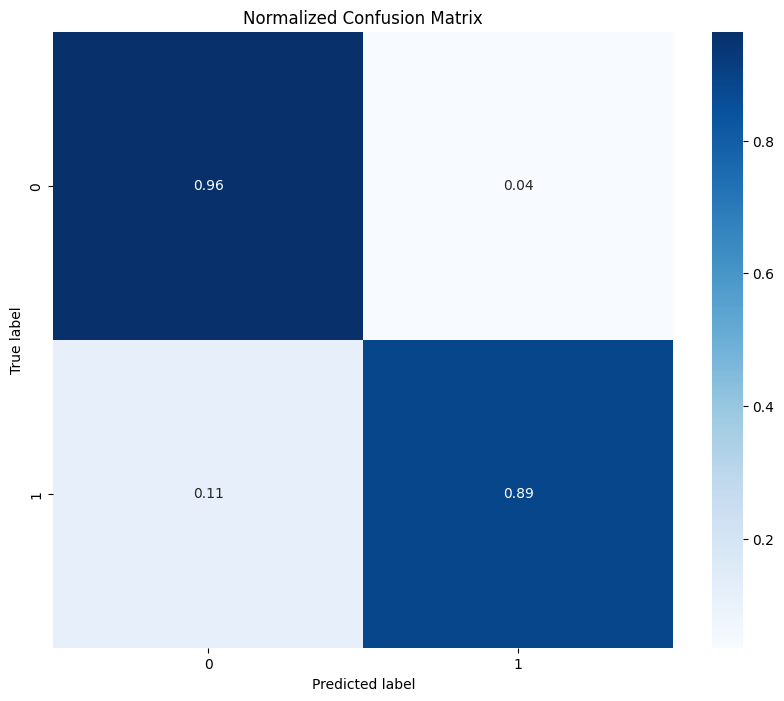

In [8]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 정규화된 혼동 행렬
cm = confusion_matrix(y_test, y_pred, normalize='true')  # 각 클래스 비율로 정규화

# 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues')  # '.2f'는 소수점 둘째 자리까지 표시
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Normalized Confusion Matrix')
plt.show()
